## Import statements

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sympy import symbols, nonlinsolve

## Generate variables and the system of equations

In [2]:
# Define symbols
a, b, c, xe = symbols('a b c xe')
xco = 0.5868 # Found by hand
Rco = 1.1463 # Found by hand
gam = 1.66 # Xenon specific gas ratio

eq1 = a - 4.5 + b*xe + c*xe**2
eq2 = b + 2*c*xe
eq3 = a - 1.1463 + b*xco + c*xco**2
eq4 = b - 0.5317 + 2*c*xco

## Solve the system of equations with a non-linear solver 

In [3]:
# Solve system nonlinsolve
solution = nonlinsolve([eq1, eq2, eq3, eq4], (a, b, c, xe))
sol_list = list(solution)

# Unpack the solution
a, b, c, xe = sol_list[0]  

# Convert to floats for NumPy
a = float(a)
b = float(b)
c = float(c)
xe = float(xe)

print(f"The a coefficient is {a}.")
print(f"The b coefficient is {b}. ")
print(f"The c coefficient is {c}. ")
print(f"The xe value is {xe}. ")

The a coefficient is 0.8270419044241857.
The b coefficient is 0.5564325684247249. 
The c coefficient is -0.021074103974714493. 
The xe value is 13.201808463419221. 


## Define the Converging-Diverging nozzle profile

In [4]:
def R_pa(x):
    return a + b*x + c*x**2

def R_ut(x):
    return -np.sqrt(2.5**2 - x**2) + 3.5

def R_dt(x):
    return -np.sqrt(1.25**2 - x**2) + 2.25

## Plotting the nozzle geometry

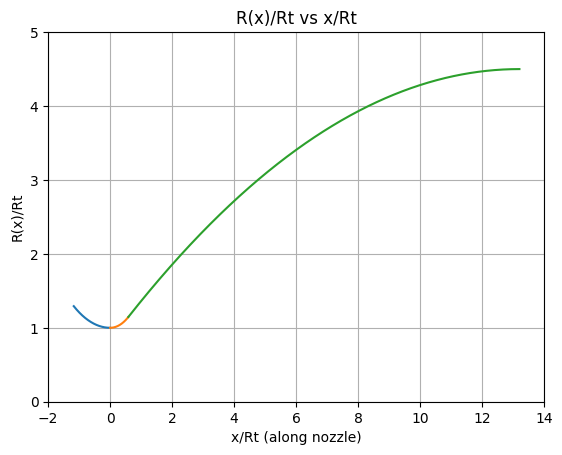

In [5]:
x_ut = np.linspace(-2*xco, 0.0, 1000)
x_dt = np.linspace(0.0, xco, 1000)
x_pa = np.linspace(xco, xe, 1000)

plt.figure(1)
plt.plot(x_ut, R_ut(x_ut))
plt.plot(x_dt, R_dt(x_dt))
plt.plot(x_pa, R_pa(x_pa))
plt.xlabel("x/Rt (along nozzle)")
plt.ylabel("R(x)/Rt")
plt.title("R(x)/Rt vs x/Rt")
plt.grid()
plt.xlim(-2, 14)
plt.ylim(0,5)
plt.show()

In [6]:
A_ut = np.pi*(R_ut(x_ut))**2
A_dt = np.pi*(R_dt(x_dt))**2
A_pa = np.pi*(R_pa(x_pa))**2

In [7]:
x_comb = np.concatenate([x_ut, x_dt, x_pa])
A_comb = list(np.concatenate([A_ut, A_dt, A_pa]))

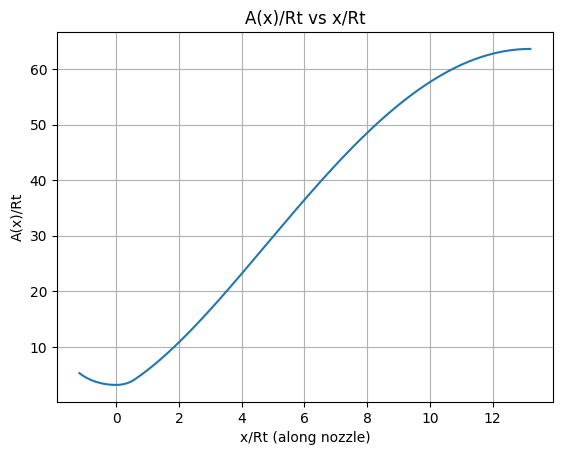

In [8]:
plt.figure(2)
plt.plot(x_comb, A_comb)
plt.grid(True)
plt.xlabel('x/Rt (along nozzle)')
plt.ylabel('A(x)/Rt')
plt.title('A(x)/Rt vs x/Rt')
plt.show()

## Mach calculations for Cases 1 and 2

In [9]:
def mach_equation(M, A_ratio):
    return (1/M) * ((2/(gam+1))*(1 + (gam-1)/2*M**2))**((gam+1)/(2*(gam-1))) - A_ratio

In [10]:
A1_star = np.min(A_comb)
throat_idx = A_comb.index(A1_star)

In [11]:
M_vals1 = np.zeros_like(A_comb)

for idx in range(len(A_comb)):
    A_ratio = A_comb[idx] / A1_star   

    M_guess = 0.2        
    M_vals1[idx] = fsolve(mach_equation, M_guess, args=(A_ratio,))[0]   


In [12]:
M_vals2 = np.zeros_like(A_comb)

for idx in range(len(A_comb)):
    A_ratio = A_comb[idx] / A1_star   
    
    if idx < throat_idx:
        M_guess = 0.2        
        M_vals2[idx] = fsolve(mach_equation, M_guess, args=(A_ratio,))[0]   

    else:
        M_guess = 7    
        M_vals2[idx] = fsolve(mach_equation, M_guess, args=(A_ratio,))[0]


## Pressure values for Cases 1 and 2

In [13]:
def pressure_equation(M):
    return (1+ ((gam-1)/2)*M**2)**((-gam)/(gam-1))

In [14]:
pres_vals1 = np.zeros_like(A_comb)

for idx in range(len(M_vals1)):
    pres_vals1[idx] = pressure_equation(M_vals1[idx])

In [15]:
pres_vals2 = np.zeros_like(A_comb)

for idx in range(len(M_vals2)):
    pres_vals2[idx] = pressure_equation(M_vals2[idx])

## Mach calculations for Case 3

In [16]:
pres_diff2 = 1 - pres_vals1[-1]
pe_p0_goal2 = pres_vals1[-1] + 0.5*pres_diff2

In [17]:
Ae_A1star = 20.25
M_guess_case3 = 0.2

M_isen = fsolve(mach_equation, M_guess_case3, args=(Ae_A1star,))[0] 
pe_p0_isen = pressure_equation(M_isen)

pe_p0_goal2 >= pe_p0_isen

True

In [18]:
def mach_equation_case3(pe_p0_desired):
    return np.sqrt((-1+(pe_p0_desired)**((1-gam)/gam))*(2/(gam-1)))

In [19]:
Me_goal2 = mach_equation_case3(pe_p0_goal2)

In [20]:
def area_ratio_equation(M):
    return ((gam+1)/2)**(-(gam+1)/(2*(gam-1)))*(1/M)*(1+((gam-1)/2)*M**2)**((gam+1)/(2*(gam-1)))

In [21]:
exit_area_ratio = area_ratio_equation(Me_goal2)
exit_area = np.pi*(20.25)
A_star_sub = exit_area/exit_area_ratio

In [22]:
M_vals3 = np.zeros_like(A_comb)

for idx in range(len(A_comb)):
    A_ratio = A_comb[idx] / A_star_sub   
    M_guess = 0.2        
    M_vals3[idx] = fsolve(mach_equation, M_guess, args=(A_ratio,))[0]   

## Mach calculations for Case 4

In [23]:
pres_diff = pres_vals1[-1] - pres_vals2[-1]
pe_p0_goal = pres_vals2[-1] + 0.75*pres_diff

In [24]:
def pe_p0_error_case4(Ans_A1star):

    M_guess_sup = 2.0
    M_guess_sub = 0.2
    Ae_A1star = 20.25

    M1_s = fsolve(mach_equation, M_guess_sup, args=(Ans_A1star,))[0]
    M2_s = np.sqrt((1 + 0.5*(gam-1)*M1_s**2)/(gam*M1_s**2 - 0.5*(gam+1)))
    
    Ans_A2star = ((gam+1)/2)**(-(gam+1)/(2*(gam-1)))*(1/M2_s)*(1 + 0.5*(gam-1)*M2_s**2)**((gam+1)/(2*(gam-1)))
    Ae_A2star = Ae_A1star*(Ans_A2star/Ans_A1star)

    Me_s = fsolve(mach_equation, M_guess_sub, args=(Ae_A2star,))[0]

    p1_p01 = (1 + 0.5*(gam-1)*M1_s**2)**(-gam/(gam-1))
    p2_p1  = 1 + (2*gam/(gam+1))*(M1_s**2 - 1)
    p02_p2 = (1 + 0.5*(gam-1)*M2_s**2)**(gam/(gam-1))
    pe_p0e = (1 + 0.5*(gam-1)*Me_s**2)**(-gam/(gam-1))

    pe_p0 = pe_p0e * p02_p2 * p2_p1 * p1_p01

    return pe_p0 - pe_p0_goal

In [25]:
Ans_A1star_initial = 2.0
Ans_A1star = fsolve(pe_p0_error_case4, Ans_A1star_initial)[0]
shock_area = np.pi*Ans_A1star

In [26]:
M_guess_sup = 2.0
M_guess_sub = 0.2
M_1s = fsolve(mach_equation, M_guess_sup, args=(Ans_A1star,))[0]
M_2s = np.sqrt((1 + 0.5*(gam-1)*M_1s**2)/(gam*M_1s**2 - 0.5*(gam+1)))

A2_star = A1_star*(((gam+1)/2)**(-(gam+1)/(2*(gam-1)))*(1/M_2s)*(1 + 0.5*(gam-1)*M_2s**2)**((gam+1)/(2*(gam-1))))

In [27]:
throat = min(A_comb)
targeted_areas = A_comb[throat_idx:]
shock_index = np.argmin(np.abs(shock_area-targeted_areas))
shock_index += len(x_ut)

In [28]:
M_vals4 = np.zeros_like(A_comb)

for i in range(shock_index + 1):
    A_ratio = A_comb[i] / A1_star
    M_vals4[i] = fsolve(mach_equation, M_guess_sup, args=(A_ratio,))[0]

for i in range(shock_index + 1, len(x_comb)):
    A_ratio = A_comb[i] / A2_star
    M_vals4[i] = fsolve(mach_equation, M_guess_sub, args=(A_ratio,))[0]

## Mach Plot

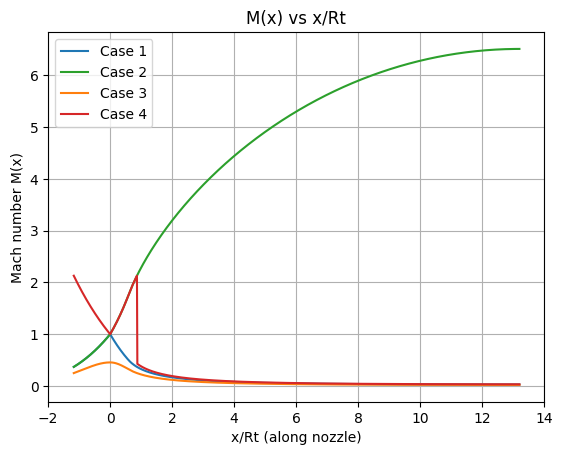

In [29]:
plt.figure(3)
plt.plot(x_comb, M_vals1, label = 'Case 1', color = 'tab:blue')
plt.plot(x_comb, M_vals2, label = 'Case 2', color = 'tab:green')
plt.plot(x_comb, M_vals3, label = 'Case 3', color = 'tab:orange')
plt.plot(x_comb, M_vals4, label = 'Case 4', color = 'tab:red')

plt.xlabel('x/Rt (along nozzle)')
plt.ylabel('Mach number M(x)')
plt.title('M(x) vs x/Rt')
plt.xlim(-2,14)
plt.grid(True)
plt.legend()
plt.show()

## Pressure values for Cases 3 and 4

In [30]:
pres_vals3 = np.zeros_like(A_comb)

for idx in range(len(M_vals3)):
    pres_vals3[idx] = pressure_equation(M_vals3[idx])

In [31]:
pres_vals4 = np.zeros_like(A_comb)

for idx in range(len(M_vals4)):
    pres_vals4[idx] = pressure_equation(M_vals4[idx])

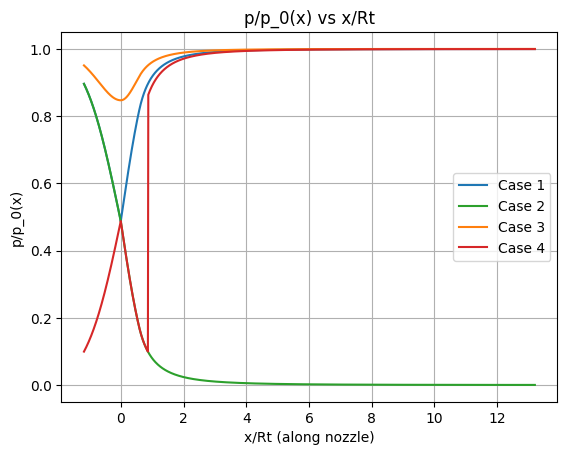

In [32]:
plt.figure(4)
plt.plot(x_comb, pres_vals1, label = 'Case 1', color = 'tab:blue')
plt.plot(x_comb, pres_vals2, label = 'Case 2', color = 'tab:green')
plt.plot(x_comb, pres_vals3, label = 'Case 3', color = 'tab:orange')
plt.plot(x_comb, pres_vals4, label = 'Case 4', color = 'tab:red')

plt.grid(True)
plt.legend()
plt.xlabel('x/Rt (along nozzle)')
plt.ylabel('p/p_0(x)')
plt.title('p/p_0(x) vs x/Rt')
plt.show()

## Density

In [33]:
def density_function(M):
    return (1+((gam-1)/2)*M**2)**(-1/(gam-1))

In [34]:
dens_vals1 = np.zeros_like(A_comb)

for idx in range(len(M_vals1)):
    dens_vals1[idx] = density_function(M_vals1[idx])

In [35]:
dens_vals2 = np.zeros_like(A_comb)

for idx in range(len(M_vals2)):
    dens_vals2[idx] = density_function(M_vals2[idx])

In [36]:
dens_vals3 = np.zeros_like(A_comb)

for idx in range(len(M_vals2)):
    dens_vals3[idx] = density_function(M_vals3[idx])

In [37]:
dens_vals4 = np.zeros_like(A_comb)

for idx in range(len(M_vals4)):
    dens_vals4[idx] = density_function(M_vals4[idx])

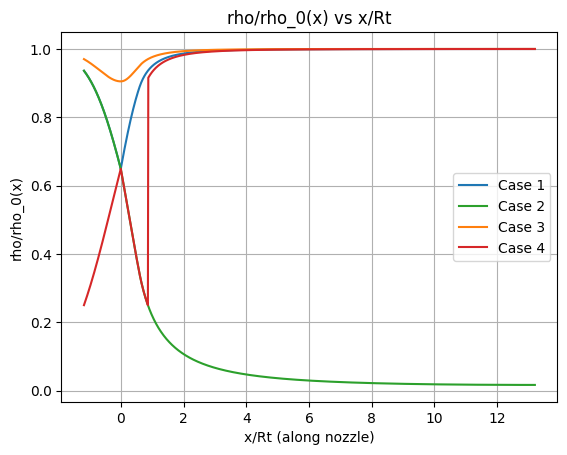

In [38]:
plt.figure(5)
plt.plot(x_comb, dens_vals1, label = 'Case 1', color = 'tab:blue')
plt.plot(x_comb, dens_vals2, label = 'Case 2', color = 'tab:green')
plt.plot(x_comb, dens_vals3, label = 'Case 3', color = 'tab:orange')
plt.plot(x_comb, dens_vals4, label = 'Case 4', color = 'tab:red')

plt.grid(True)
plt.legend()
plt.xlabel('x/Rt (along nozzle)')
plt.ylabel('rho/rho_0(x)')
plt.title('rho/rho_0(x) vs x/Rt')
plt.show()

## Temperature

In [39]:
def temp_equation(M):
    return (1 + (gam-1)/2*M**2)**(-1)

In [40]:
temp_vals1 = np.zeros_like(x_comb)

for idx in range(len(M_vals1)):
    temp_vals1[idx] = temp_equation(M_vals1[idx])

In [41]:
temp_vals2 = np.zeros_like(x_comb)

for idx in range(len(M_vals2)):
    temp_vals2[idx] = temp_equation(M_vals2[idx])

In [42]:
temp_vals3 = np.zeros_like(x_comb)

for idx in range(len(M_vals3)):
    temp_vals3[idx] = temp_equation(M_vals3[idx])

In [43]:
temp_vals4 = np.zeros_like(x_comb)

for idx in range(len(M_vals4)):
    temp_vals4[idx] = temp_equation(M_vals4[idx])

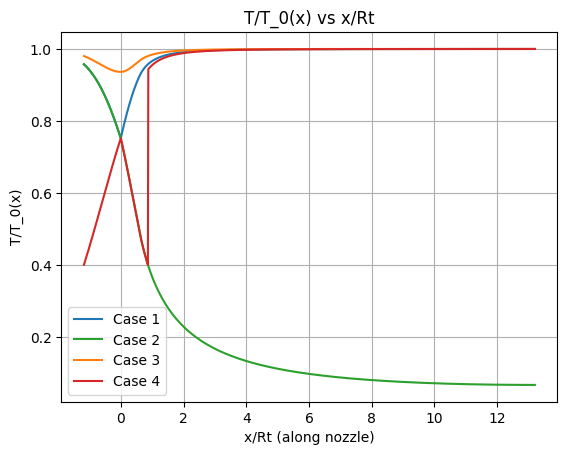

In [44]:
plt.figure(6)
plt.plot(x_comb, temp_vals1, label = 'Case 1', color = 'tab:blue')
plt.plot(x_comb, temp_vals2, label = 'Case 2', color = 'tab:green')
plt.plot(x_comb, temp_vals3, label = 'Case 3', color = 'tab:orange')
plt.plot(x_comb, temp_vals4, label = 'Case 4', color = 'tab:red')

plt.grid(True)
plt.legend()
plt.xlabel('x/Rt (along nozzle)')
plt.ylabel('T/T_0(x)')
plt.title('T/T_0(x) vs x/Rt')
plt.show()

## Speed over speed of sound at throat calculations

In [45]:
mm_Xe = 0.13129
R_univ = 8.3145
R_Xe = R_univ / mm_Xe 

throat_temp = temp_vals1[throat_idx]
a_t = np.sqrt(throat_temp*gam*R_Xe)

In [46]:
def speed_of_sound(T):
    return np.sqrt(gam*R_Xe*T)

In [47]:
SoS_1 = np.zeros_like(A_comb)
u_1 = np.zeros_like(A_comb)

for idx in range(len(A_comb)):
    SoS_1[idx] = speed_of_sound(temp_vals1[idx])
    u_1[idx] =  M_vals1[idx]*SoS_1[idx]

u_1_at = u_1/a_t

In [48]:
SoS_2 = np.zeros_like(A_comb)
u_2 = np.zeros_like(A_comb)

for idx in range(len(A_comb)):
    SoS_2[idx] = speed_of_sound(temp_vals2[idx])
    u_2[idx] =  M_vals2[idx]*SoS_2[idx]

u_2_at = u_2/a_t

In [49]:
SoS_3 = np.zeros_like(A_comb)
u_3 = np.zeros_like(A_comb)

for idx in range(len(A_comb)):
    SoS_3[idx] = speed_of_sound(temp_vals3[idx])
    u_3[idx] =  M_vals3[idx]*SoS_3[idx]

u_3_at = u_3/a_t

In [50]:
SoS_4 = np.zeros_like(A_comb)
u_4 = np.zeros_like(A_comb)

for idx in range(len(A_comb)):
    SoS_4[idx] = speed_of_sound(temp_vals4[idx])
    u_4[idx] =  M_vals4[idx]*SoS_4[idx]

u_4_at = u_4/a_t

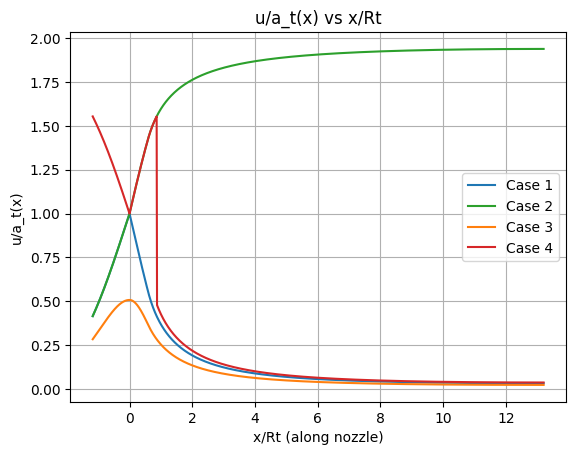

In [51]:
plt.figure(6)
plt.plot(x_comb, u_1_at, label = 'Case 1', color = 'tab:blue')
plt.plot(x_comb, u_2_at, label = 'Case 2', color = 'tab:green')
plt.plot(x_comb, u_3_at, label = 'Case 3', color = 'tab:orange')
plt.plot(x_comb, u_4_at, label = 'Case 4', color = 'tab:red')

plt.grid(True)
plt.legend()
plt.xlabel('x/Rt (along nozzle)')
plt.ylabel('u/a_t(x)')
plt.title('u/a_t(x) vs x/Rt')
plt.show()